# Analysing non-spinflip polarised NR data

Currently (5/Aug/2021) `refnx` does not have the ability to fully analyse polarised neutron reflectometry data. However, it can be used to analyse the non-spinflip channels of a polarised neutron reflectometry measurement. Here we demonstrate how to do this using auxiliary `Parameter`. The datasets of interest have the structure:

`Si | SiO2 | Permalloy | Au | 2-mercaptoethanol | D2O`

In [1]:
# some necessary imports
import os.path
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import refnx
from refnx.analysis import Parameter, Objective, CurveFitter, GlobalObjective
from refnx.reflect import SLD, Slab, Structure, ReflectModel
from refnx.dataset import Data1D
from refnx._lib import flatten

In [2]:
# create datasets from the NSF PNR data
pth = os.path.dirname(refnx.__file__)
dd = 'c_PLP0007882.dat'
uu = 'c_PLP0007885.dat'

file_path_uu = os.path.join(pth, 'reflect', 'test', uu)
file_path_dd = os.path.join(pth, 'reflect', 'test', dd)

data_uu = Data1D(file_path_uu)
data_dd = Data1D(file_path_dd)

In [3]:
# create SLD (Scattering Length Density) objects for each of the materials
si = SLD(2.07, name="Si")
sio2 = SLD(3.47, name="SiO2")
au = SLD(4.66, name="Au")
mercapto = SLD(3.49, name="2-mercaptoethanol")
d2o = SLD(6.35, name="d2o")

# to describe the Permalloy layer we're going to create parameters to describe the nuclear
# and magnetic parts of the SLD. Instead of using the magnetic moment and angle we
# could just use a magnetic SLD

nuclear_py = Parameter(9.0, name="Py nuclear part")
mag_moment_py = Parameter(600, name="Py emu/cc")
angle = Parameter(0, name="angle", bounds=(0, 90.))

# Now create two SLD objects for the Permalloy layer, one for the UU channel, one for the DD channel.
# don't worry that the SLD is set to zero to start with

py_dd = SLD(0.0, name="Py DD SLD")
py_uu = SLD(0.0, name="Py UU SLD")

# Now we make constraints for the SLD objects. Each SLD object has two parameters,
# SLD.real and SLD.imag. The conversion factor of 2.85e-3 converts the magnetic moment
# from emu/cc to 10**-6 Å**-2
py_dd.real.constraint = nuclear_py - mag_moment_py * 2.85e-3 * np.cos(angle*np.pi/180)
py_uu.real.constraint = nuclear_py + mag_moment_py * 2.85e-3 * np.cos(angle*np.pi/180)

In [4]:
# let's check on the SLDs. Observe that the SLDs obey the constraints

complex(py_dd), complex(py_uu)

((7.29+0j), (10.71+0j))

In [5]:
# let's try altering the magnetic part and see if the values are updated in the SLDs.
# `magnetic_Fe` is a Parameter, and Parameter values are modified like this:

mag_moment_py.value = 700

# note how both the SLD objects are updated.

complex(py_dd), complex(py_uu)

((7.005+0j), (10.995000000000001+0j))

In [6]:
# Now make Slabs that describe each layer. These can either be made from SLD objects,
# or by using the `Slab` constructor directly.

# sio2 slab has a thickness of 20 and roughness of 4 with the Si fronting medium
sio2_l = sio2(20, 4)

au_l = au(215, 4)
mercapto_l = mercapto(8, 4)
d2o_l = d2o(0, 4)

# now make the Fe layers for each of the spin channels. Note that we create
# Parameter for the thickness and roughness which will be shared over both spin channels.

py_thickness = Parameter(50, name="Py thickness")
py_roughness = Parameter(5, name="Py roughness")

py_dd_l = Slab(py_thickness, py_dd, py_roughness, name="Py dd slab")
py_uu_l = Slab(py_thickness, py_uu, py_roughness, name="Py uu slab")

In [7]:
# now we make structures for each of the spin channels
# note that we use the same `sio2_l` for each of the structures. This
# will share the same sio2 thickness and roughness in the structures
# and will reduce parameter numbers in a fit

s_dd = si | sio2_l | py_dd_l | au_l | mercapto_l | d2o_l
s_uu = si | sio2_l | py_uu_l | au_l | mercapto_l | d2o_l

In [8]:
# The total number of parameters is reduced by sharing Parameter/SLD/Slab objects
# over the two structures.

# what are the number of parameters in each of the structures?
print(len(list(flatten(s_dd.parameters))), len(list(flatten(s_uu.parameters))))

# now what are the number of unique parameters in both parameter sets?
combined_set = set(flatten(s_dd.parameters)).union(set(flatten(s_uu.parameters)))
print(len(combined_set))

# this shows that the unique number of parameters over both datasets is 36, reduced from 60.
# i.e. there are parameters that are joint over both datasets

30 30
36


In [9]:
# now place the Structures into a ReflectModel. ReflectModel applies resolution smearing, etc.

model_dd = ReflectModel(s_dd)
model_uu = ReflectModel(s_uu)

In [10]:
objective_dd = Objective(model_dd, data_dd, 
                         auxiliary_params=(nuclear_py, mag_moment_py, angle))
objective_uu = Objective(model_uu, data_uu, 
                         auxiliary_params=(nuclear_py, mag_moment_py, angle))

global_objective = GlobalObjective([objective_dd, objective_uu])

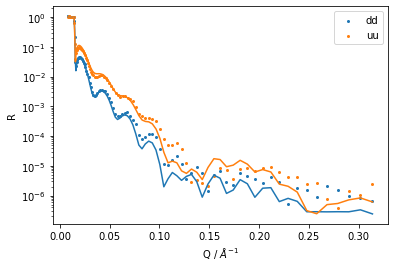

In [11]:
fig, ax = plt.subplots()
plt.scatter(data_dd.x, data_dd.y, label="dd", s=4)
plt.plot(data_dd.x, objective_dd.generative())

plt.scatter(data_uu.x, data_uu.y, label="uu", s=4)
plt.plot(data_uu.x, objective_uu.generative())

plt.ylabel("R")
plt.xlabel("Q / $\AA^{-1}$")
plt.yscale('log')
plt.legend();

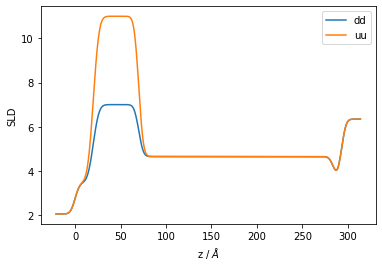

In [12]:
plt.plot(*s_dd.sld_profile(), label='dd')
plt.plot(*s_uu.sld_profile(), label="uu")
plt.ylabel("SLD")
plt.xlabel("z / $\AA$")
plt.legend();

In [13]:
# select the parameters to be fitted and their bounds
model_uu.scale.setp(vary=True, bounds=(0.9, 1.1))
model_uu.bkg.setp(vary=True, bounds=(1e-7, 5e-6))
model_dd.scale.setp(vary=True, bounds=(0.9, 1.1))
model_dd.bkg.setp(vary=True, bounds=(1e-7, 5e-6))

sio2_l.thick.setp(vary=True, bounds=(10, 25))
sio2_l.rough.setp(vary=True, bounds=(1, 8))

py_thickness.setp(vary=True, bounds=(38, 55))
py_roughness.setp(vary=True, bounds=(1, 8))
nuclear_py.setp(vary=True, bounds=(8.5, 9.5))
mag_moment_py.setp(vary=True, bounds=(500, 800))

au_l.thick.setp(vary=True, bounds=(200, 240))
au_l.rough.setp(vary=True, bounds=(1, 8))
au.real.setp(vary=True, bounds=(4.5, 4.66))

mercapto_l.thick.setp(vary=True, bounds=(5, 15))
mercapto_l.rough.setp(vary=True, bounds=(1, 8))
mercapto.real.setp(vary=True, bounds=(3, 4))

d2o_l.rough.setp(vary=True, bounds=(1, 8))
d2o.real.setp(vary=True, bounds=(6.2, 6.36))

In [14]:
fitter = CurveFitter(global_objective)

In [15]:
fitter.fit('differential_evolution', seed=1);

77it [00:51,  1.51it/s]


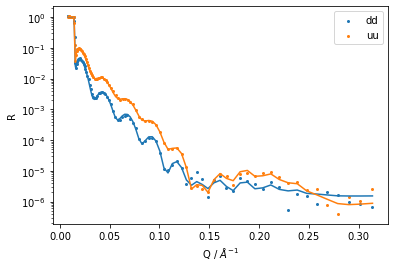

In [16]:
fig, ax = plt.subplots()
plt.scatter(data_dd.x, data_dd.y, label="dd", s=4)
plt.plot(data_dd.x, objective_dd.generative())

plt.scatter(data_uu.x, data_uu.y, label="uu", s=4)
plt.plot(data_uu.x, objective_uu.generative())

plt.ylabel("R")
plt.xlabel("Q / $\AA^{-1}$")
plt.yscale('log')
plt.legend();

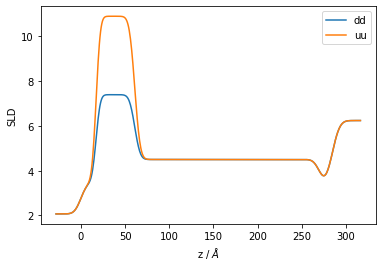

In [17]:
plt.plot(*s_dd.sld_profile(), label='dd')
plt.plot(*s_uu.sld_profile(), label="uu")
plt.ylabel("SLD")
plt.xlabel("z / $\AA$")
plt.legend();

By printing out the objectives we can see what the parameters are. Here we see that the Permalloy magnetic moment is 615 emu/cc, with a nuclear SLD of $9.15\times10^{-6}Å^{-2}$

In [18]:
print(objective_dd)

________________________________________________________________________________
Objective - 140698445453824
Dataset = c_PLP0007882
datapoints = 94
chi2 = 301.3613165434196
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:      None      
<Parameter:'Py nuclear part', value=9.14537 +/- 0.0239, bounds=[8.5, 9.5]>
<Parameter:  'Py emu/cc'  , value=614.615 +/- 4.88 , bounds=[500.0, 800.0]>
<Parameter:    'angle'    , value=0 (fixed)  , bounds=[0.0, 90.0]>
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.995443 +/- 0.00293, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=1.47825e-06 +/- 1.9e-07, bounds=[1e-07, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q